# CAPM Calculations with Exponential Weights #

### CAPM Model using Weighted Linear Regression Model ###

In [1]:
# Import Libraries

# Data Management
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from data_downloader import get_market_data

In [2]:
# Weights
def wexp(N, half_life):
    c = np.log(0.5) / half_life
    n = np.array(range(N))
    w = np.exp(c * n)
    return np.flip(w / np.sum(w))

# Create the CAPM Function
def capm_regression(
    excess_stock: pd.Series,
    excess_benchmark: pd.Series,
    window: int = 252,
    WLS: bool = False,
):
    
    X = excess_benchmark
    y = excess_stock
    
    if WLS:
        # Create weights with exponential decay
        weights = window * wexp(window, window/2)
        
        # Fit WLS regression
        model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()
    
    else:
        # Fit OLS regression
        model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()
    
    return model
    
    
def rolling_capm_regression(
    stock_returns: pd.Series,
    benchmark_returns: pd.Series,
    daily_rfr: pd.Series,
    window: int = 252,
    WLS: bool = False,
):

    #Align Data
    df = pd.concat([stock_returns, benchmark_returns, daily_rfr], axis=1)
    df = df.dropna()
    df.columns = ['stock_returns', 'benchmark_returns', 'daily_returns']

    # Compute Excess Returns
    excess_stock = df['stock_returns'] - df['daily_returns']
    excess_benchmark = df['benchmark_returns'] - df['daily_returns']

    # Lists
    alphas, betas, sigma = [], [], []
    p_values_alpha, p_values_beta = [], []
    r_squared = []
    dates = []

    for t in range(window, len(excess_stock)):
        # The variables
        X = excess_benchmark.iloc[t-window:t]
        y = excess_stock.iloc[t-window:t]

        # Create the Model
        model = capm_regression(y, X, window=window, WLS=WLS)

        # Avoid KeyError by checking if params exist
        params = model.params
        pvalues = model.pvalues
        r2 = model.rsquared
        hsigma = (model.resid).std()

        # Append values
        alphas.append(params.iloc[0])
        betas.append(params.iloc[1])
        sigma.append(hsigma)
        p_values_alpha.append(pvalues.iloc[0])
        p_values_beta.append(pvalues.iloc[1])
        r_squared.append(r2)
        dates.append(excess_stock.index[t - 1])  # Last date to calculate betas
            
    parameters = pd.DataFrame({
        'alpha': alphas,
        'beta': betas,
        'sigma': sigma,
        'p_value_alpha': p_values_alpha,
        'p_value_beta': p_values_beta,
        'r_squared': r_squared,
    }, index=pd.Index(dates, name="date"))
    
    return parameters

In [7]:
# Get the important data for the Risk-Free Rate
rfr = pd.read_csv(r"..\additional_data\risk_free_rate.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index)
rfr = rfr.loc['2010-01-05':]

rfr

,risk_free_rate
Date,
2010-01-05,0.000104
2010-01-06,0.000106
2010-01-07,0.000106
2010-01-08,0.000106
2010-01-11,0.000106
...,...
2024-12-24,0.000128
2024-12-26,0.000127
2024-12-27,0.000128


In [8]:
# Benchmark Data
benchmark = pd.read_csv(r'..\additional_data\benchmark_returns.csv')
benchmark.set_index('Date', inplace=True)
benchmark.index = pd.to_datetime(benchmark.index)
benchmark = benchmark.loc['2010-01-05':]

benchmark

,benchmark_returns
Date,
2010-01-05,0.003111
2010-01-06,0.000545
2010-01-07,0.003993
2010-01-08,0.002878
2010-01-11,0.001745
...,...
2024-12-24,0.010982
2024-12-26,-0.000406
2024-12-27,-0.011117


In [9]:
# Stock Data
ticker = 'NVDA'

df_stock = get_market_data(
        ticker=ticker, 
        start_date='2010-01-01', 
        end_date='2025-01-01', 
        returns=True
    )

df_stock

Price,close,high,low,open,volume,returns
Date,,,,,,
2010-01-05,0.430043,0.434628,0.422249,0.422249,728648000,0.014497
2010-01-06,0.432794,0.433711,0.425688,0.429814,649168000,0.006377
2010-01-07,0.424313,0.432336,0.421103,0.430502,547792000,-0.019792
2010-01-08,0.425230,0.428210,0.418353,0.420874,478168000,0.002159
2010-01-11,0.419270,0.429356,0.413309,0.427522,556612000,-0.014115
...,...,...,...,...,...,...
2024-12-24,140.197372,141.877094,138.627618,139.977407,105157000,0.003930
2024-12-26,139.907410,140.827275,137.707768,139.677451,116205600,-0.002070
2024-12-27,136.987885,138.997570,134.688268,138.527645,170582600,-0.021088


In [10]:
# Calculate the Betas using WLS
betas_wls = rolling_capm_regression(
    df_stock['returns'],
    benchmark['benchmark_returns'],
    rfr['risk_free_rate'],
    WLS = True
)

betas_wls

,alpha,beta,sigma,p_value_alpha,p_value_beta,r_squared
date,,,,,,
2011-01-03,-0.000148,1.402191,0.021868,0.913758,2.325074e-23,0.327949
2011-01-04,-0.000175,1.401956,0.021856,0.897795,2.300755e-23,0.328005
2011-01-05,0.000293,1.420018,0.022266,0.835463,1.261499e-22,0.318870
2011-01-06,0.001323,1.396809,0.023759,0.400990,1.866986e-18,0.265014
2011-01-07,0.001543,1.392110,0.023838,0.328520,3.196135e-18,0.261880
...,...,...,...,...,...,...
2024-12-23,0.001147,2.551350,0.024974,0.461385,4.904376e-31,0.416017
2024-12-24,0.001001,2.523614,0.025030,0.520761,1.240832e-30,0.411689
2024-12-26,0.000992,2.524104,0.025029,0.523588,1.224710e-30,0.411750


In [11]:
# Calculate the Betas using OLS
betas_ols = rolling_capm_regression(
    df_stock['returns'],
    benchmark['benchmark_returns'],
    rfr['risk_free_rate'],
    WLS = False,
)

betas_ols

,alpha,beta,sigma,p_value_alpha,p_value_beta,r_squared
date,,,,,,
2011-01-03,-0.001244,1.449276,0.021861,0.368415,3.499126e-26,0.361753
2011-01-04,-0.001288,1.448350,0.021850,0.351343,3.552496e-26,0.361676
2011-01-05,-0.001049,1.457845,0.022262,0.456100,1.034556e-25,0.356232
2011-01-06,-0.000418,1.449920,0.023751,0.780508,4.289743e-23,0.324675
2011-01-07,-0.000290,1.447889,0.023830,0.847430,6.296665e-23,0.322615
...,...,...,...,...,...,...
2024-12-23,0.001905,2.684333,0.024952,0.229952,2.985311e-31,0.418319
2024-12-24,0.001849,2.667374,0.025004,0.245206,5.149148e-31,0.415791
2024-12-26,0.001852,2.668395,0.025003,0.244129,5.085132e-31,0.415849


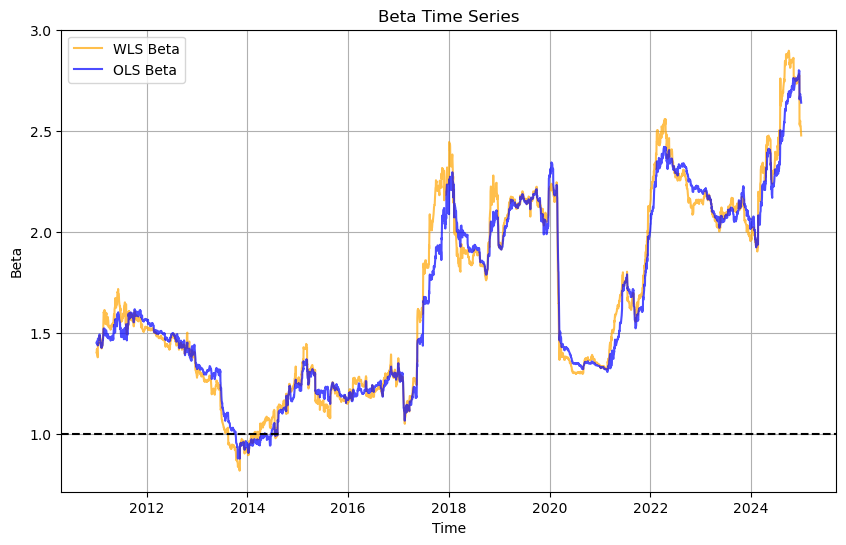

In [12]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['beta'], label='WLS Beta', color='orange', alpha=0.7)
plt.plot(betas_ols['beta'], label='OLS Beta', color='blue', alpha=0.7)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()

# Show
plt.grid()
plt.show()

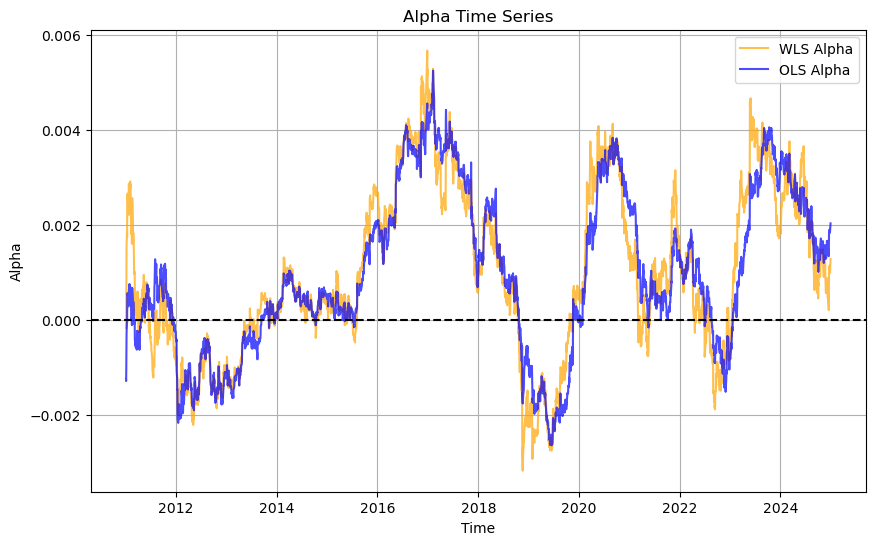

In [13]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['alpha'], label='WLS Alpha', color='orange', alpha=0.7)
plt.plot(betas_ols['alpha'], label='OLS Alpha', color='blue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Alpha Time Series')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()

# Show
plt.grid()
plt.show()

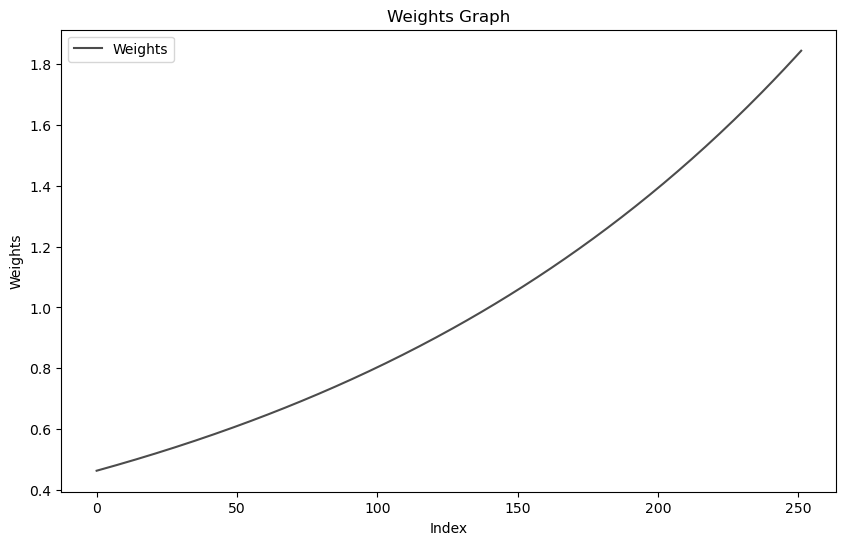

In [14]:
# Create Plot
weights = 252 * wexp(252, 126)

plt.figure(figsize=(10, 6))
plt.plot(weights, label='Weights', color='black', alpha=0.7)

# Config
plt.title('Weights Graph')
plt.xlabel('Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.show()

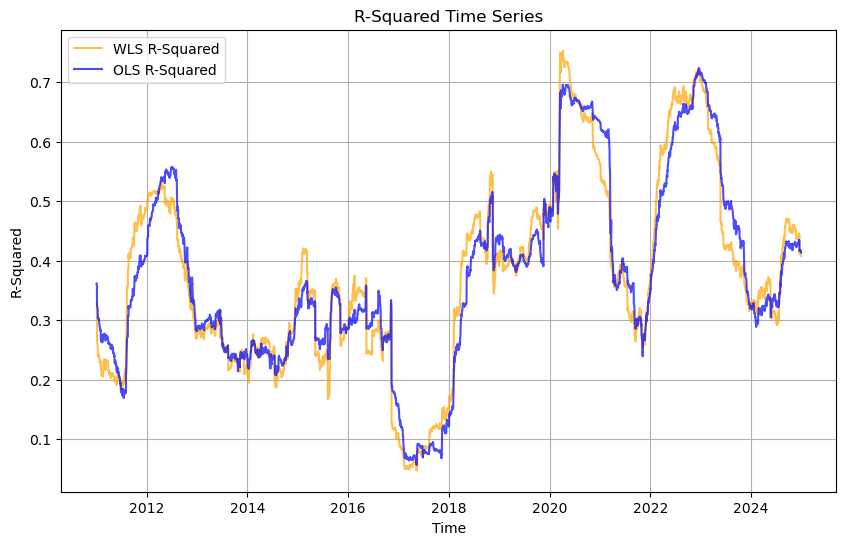

In [15]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['r_squared'], label='WLS R-Squared', color='orange', alpha=0.7)
plt.plot(betas_ols['r_squared'], label='OLS R-Squared', color='blue', alpha=0.7)

# Config
plt.title('R-Squared Time Series')
plt.xlabel('Time')
plt.ylabel('R-Squared')
plt.legend()

# Show
plt.grid()
plt.show()

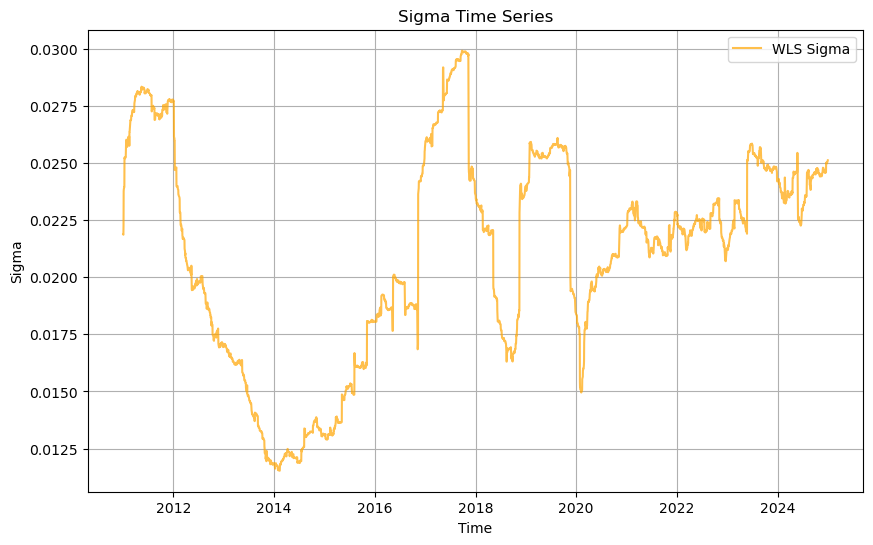

In [16]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['sigma'], label='WLS Sigma', color='orange', alpha=0.7)

# Config
plt.title('Sigma Time Series')
plt.xlabel('Time')
plt.ylabel('Sigma')
plt.legend()

# Show
plt.grid()
plt.show()

In [17]:
# Compute the Factor Contribution to Returns
def compute_factor_contributions(factor_returns, betas):
    # Multiply Elements
    contribution = (factor_returns * betas)

    return contribution

# Compute the Residual Returns
def compute_residual_returns(stock_excess_returns, factor_contributions):
    return stock_excess_returns - factor_contributions

In [19]:
# Create the Residual Returns DF
capm_returns_df = pd.DataFrame(index=betas_wls.index)

capm_returns_df['stock_excess_returns'] = df_stock['returns'] - rfr['risk_free_rate']
capm_returns_df['market_excess_returns'] = benchmark['benchmark_returns'] - rfr['risk_free_rate']
capm_returns_df['betas'] = betas_wls['beta']

capm_returns_df['factor_returns'] = compute_factor_contributions(
    capm_returns_df['market_excess_returns'], 
    capm_returns_df['betas']
)

capm_returns_df['residual_returns'] = compute_residual_returns(
    capm_returns_df['stock_excess_returns'],
    capm_returns_df['factor_returns']
)

capm_returns_df

,stock_excess_returns,market_excess_returns,betas,factor_returns,residual_returns
date,,,,,
2011-01-03,0.026815,0.011158,1.402191,0.015646,0.011169
2011-01-04,-0.003258,-0.001407,1.401956,-0.001972,-0.001286
2011-01-05,0.073830,0.004898,1.420018,0.006955,0.066875
2011-01-06,0.129527,-0.002220,1.396809,-0.003101,0.132628
2011-01-07,0.027460,-0.001939,1.392110,-0.002699,0.030159
...,...,...,...,...,...
2024-12-23,0.036105,0.007133,2.551350,0.018199,0.017906
2024-12-24,0.003803,0.010855,2.523614,0.027393,-0.023590
2024-12-26,-0.002198,-0.000533,2.524104,-0.001345,-0.000852


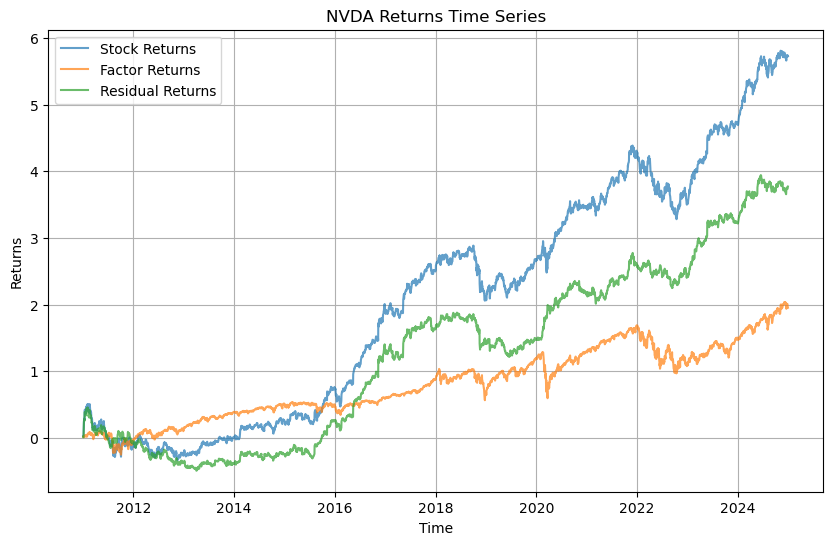

In [20]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(capm_returns_df['stock_excess_returns'].cumsum(), label='Stock Returns', alpha=0.7)
plt.plot(capm_returns_df['factor_returns'].cumsum(), label='Factor Returns', alpha=0.7)
plt.plot(capm_returns_df['residual_returns'].cumsum(), label='Residual Returns', alpha=0.7)

# Config
plt.title(f'{ticker} Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.grid()
plt.show()

### Variance Decomposition ###

Variance Decomposition

1) $ \mathrm{Var}(\mu_i) = \mathrm{Var}(\beta_0 + \beta_1\mu_M + u_i) $

Distributing the Variance Operator (assuming betas are constant):

2) $ \mathrm{Var}(\mu_i) = \mathrm{Var}(\beta_0) + \mathrm{Var}(\beta_1\mu_M ) + \mathrm{Var}(u_i)$
3) $ \sigma_i^2 = \beta_1^2\sigma_M^2 + \sigma_u^2 $

Recalling the alternative calculation of the beta coefficient (check the guide in the Module 4 Files)

4) $ \sigma_i^2 = \left( \rho_{i,M}\frac{\sigma_i}{\sigma_M} \right)^2 \sigma_M^2 + \sigma_u^2 $
5) $ \sigma_i^2 = \rho_{i,M}^2\sigma_i^2 + \sigma_u^2 $

Finally, solving for the variance of the errors:

6) $ \left( 1 - \rho_{i,M}^2 \right) \sigma_i^2 = \sigma_u^2 $

In [22]:
# First Calculate the Variance of the Stock
stock_variance = df_stock['returns'].var()

stock_variance

0.0008077681853001824

In [23]:
# Now calculate the Variance of the Market
market_variance = benchmark['benchmark_returns'].var()

market_variance

0.00011856024022996

In [24]:
# And the Residuals Variance
stocks_market_corr = df_stock['returns'].corr(benchmark['benchmark_returns'])

resid_variance = (1 - stocks_market_corr*stocks_market_corr) * stock_variance

resid_variance

0.00048785369530467024

In [25]:
beta_model = capm_regression(
    df_stock['returns'],
    benchmark['benchmark_returns'],
    rfr['risk_free_rate'],
    WLS = False,
)

print(beta_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     2473.
Date:                Mon, 04 Aug 2025   Prob (F-statistic):               0.00
Time:                        23:15:01   Log-Likelihood:                 9032.3
No. Observations:                3773   AIC:                        -1.806e+04
Df Residuals:                    3771   BIC:                        -1.805e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0008      0.00

In [26]:
# Extract the beta
beta = beta_model.params.iloc[1]

beta

1.6426590105580017

In [27]:
# Calculated Stock Variance
calculated_stock_variance = (beta*beta * market_variance) + resid_variance

calculated_stock_variance

0.000807768185300182

In [28]:
# Note that the error is practically 0
(stock_variance - calculated_stock_variance).round(2)

0.0

In [29]:
# Now check how much of the variance is explained by the Market and how much by the errors

print(f'Residuals Variance Percentage: {(resid_variance / stock_variance).round(5) * 100}%')
print(f'Market Variance Percentage: {100 - ((resid_variance / stock_variance).round(5) * 100)}%')

Residuals Variance Percentage: 60.394999999999996%
Market Variance Percentage: 39.605000000000004%
